In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from swag import SWAG
from models import SimpleNet, ConvNN
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights

# Check functions validity

In [2]:
net = SimpleNet()
print(net)

SimpleNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
# Get params in 1D and the lookups
params_1d, shape_lookup, len_lookup = model_param_to_1D(net)

# Recover model_params
model_params = params_1d_to_weights(params_1d, shape_lookup, len_lookup)
train_weights = model_params[3].detach().numpy()

In [4]:
# Create new net with weights
new_net = create_NN_with_weights(SimpleNet, model_params)

# Test if the params are still the same
new_params = nn.ParameterList(new_net.parameters())
test_weights = new_params[3].detach().numpy()

assert np.all(test_weights == train_weights)

In [5]:
print(new_net)

SimpleNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# SWAG Training

In [6]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR


In [7]:
swag = SWAG(ConvNN, K = 2)

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  dog plane  ship  deer


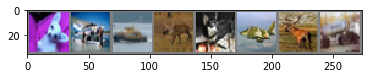

In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
# Compile swa
objective = 'classification'
lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = CosineAnnealingLR
swa_scheduler = LambdaLR

swag.compile(objective, lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

In [11]:
# Fit swag
first_mom, second_mom, D = swag.fit(trainloader,
                                    train_epoch=2,
                                    swag_epoch=2)

Begin NN model training:
[Epoch: 1, Iteration:  2000] Training Loss: 2.2656
[Epoch: 1, Iteration:  4000] Training Loss: 1.8294
[Epoch: 1, Iteration:  6000] Training Loss: 1.6109
[Epoch: 2, Iteration:  2000] Training Loss: 1.4932
[Epoch: 2, Iteration:  4000] Training Loss: 1.4484
[Epoch: 2, Iteration:  6000] Training Loss: 1.3961

Begin SWAG training:
[Epoch: 1, Iteration:  2000] Training Loss: 1.3248
[Epoch: 1, Iteration:  4000] Training Loss: 1.2902
[Epoch: 1, Iteration:  6000] Training Loss: 1.2624
[Epoch: 2, Iteration:  2000] Training Loss: 1.2067
[Epoch: 2, Iteration:  4000] Training Loss: 1.1823
[Epoch: 2, Iteration:  6000] Training Loss: 1.1845


In [12]:
first_mom.shape, second_mom.shape, D.shape

((62006,), (62006,), (62006, 2))

In [13]:
# Test prediction
testiter = iter(testloader)
X_test, y_test = testiter.next()

In [14]:
predictions = swag.predict(X_test, classes, first_mom, second_mom, D, S=1)

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.875